# Macro research
## NASDAQ vs S&P 500 - 2000 vs now


### Introduction

-  The world is currently experiencing more conflicts than at any time since the post-9/11 Iraq war.
-  I believe the risk of nuclear war is at its highest level since the Cold War.
-  Despite these risks, the S&P 500 keeps reaching new highs, driven by the ChatGPT initiated tech boom.
-  Markets seem aware of war risks, as shown by Bitcoin's quick drop when Iran attacked Israel with war drones. S&P 500 did not reflect this drop as it was a Sunday.
-  This leads me to believe that that markets believe AI's economic benefits outweigh the potential negative impacts of war.
-  This study aims to:
  1. Measure the positive effects of AI and negative effects of war on the economy
  2. Analyze how these 2 factors are currently priced into markets
  3. Compare the current situations with the 2000 tech boom and Cold War era to identify possible future scenarios.

In [1]:
import pandas as pd
from yahooquery import Ticker
from fredapi import Fred
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Initialize Yahoo Finance and FRED tickers
yahoo_tickers = {
    # Equity Indices
    "^GSPC": "S&P 500",
    "^N225": "Nikkei 225",
    "^FTSE": "FTSE 100",
    "^HSI": "Hang Seng Index",
    "^IXIC": "NASDAQ Composite",

    # Fixed Income
    "^TNX": "10-Year Treasury Yield",
    "^TYX": "30-Year Treasury Yield",
    "^FVX": "5-Year Treasury Yield",
    "^IRX": "13-Week Treasury Bill Yield",

    # Volatility
    "^VIX": "CBOE Volatility Index",

    # Crypto
    "BTC-USD": "Bitcoin_USD",
}

fred_series = {
    # Growth and Employment
    'GDP': 'Gross Domestic Product',
    'UNRATE': 'Unemployment Rate',
    'INDPRO': 'Industrial Production',
    'PAYEMS': 'Nonfarm Payrolls',
    'CIVPART': 'Labor Force Participation Rate',

    # Inflation and Prices
    'CPIAUCSL': 'Consumer Price Index',
    'PPIACO': 'Producer Price Index',
    'PCEPILFE': 'Core PCE Price Index',

    # Trade and Globalization
    'BOPGSTB': 'Trade Balance',
    'DTWEXBGS': 'US Dollar Index',

    # Financial Conditions
    'FEDFUNDS': 'Federal Funds Rate',
    'T10Y2Y': '10-Year Treasury Minus 2-Year Treasury Spread',
    'BAA10Y': 'Moody’s BAA Corporate Bond Yield Spread',
    'STLFSI': 'St. Louis Fed Financial Stress Index',
    
    # Liquidity Indicators
    'WALCL': 'Federal Reserve Balance Sheet',
    'M1SL': 'M1 Money Stock',  # NARROW
    'M2SL': 'M2 Money Stock',
    'RRPONTSYD': 'Overnight Reverse Repo Agreements',
    'TOTALSL': 'Total Assets, Liquidity Facilities',
    'DFF': 'Effective Federal Funds Rate'
}

# Initialize data containers
yahoo_data = {}
fred_data = {}

# Fetch data from Yahoo Finance
for ticker, name in yahoo_tickers.items():
    try:
        data = Ticker(ticker)
        history = data.history(period="max")
        if not history.empty:  # Ensure data exists for the ticker
            history['Ticker'] = ticker
            history['Name'] = name
            yahoo_data[ticker] = history
            print(f"Fetched data for {name} ({ticker})")
        else:
            print(f"No data for {name} ({ticker})")
            
    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")

# Fetch data from FRED API (ensure you replace the API key with your own)
fred_api_key = os.getenv('FRED_API_KEY')  # Replace with your FRED API key or set it as an environment variable
fred = Fred(api_key=fred_api_key)

for series_id, series_name in fred_series.items():
    try:
        series_data = fred.get_series(series_id)
        if series_data is not None and not series_data.empty:  # Ensure data exists for the series
            series_df = pd.DataFrame(series_data, columns=['Value'])
            series_df['Ticker'] = series_id
            series_df['Name'] = series_name
            fred_data[series_id] = series_df
            print(f"Fetched data for {series_name} ({series_id})")
        else:
            print(f"No data for {series_name} ({series_id})")
            
    except Exception as e:
        print(f"Error fetching data for {series_name} ({series_id}): {e}")

# Define time periods and their corresponding colors
time_periods = {
    "2000 Tech Boom": ("1995-01-01", "2002-12-31")
}
time_period_colors = {
    "2000 Tech Boom": "lightcoral"
}

# Combine Yahoo Finance data into a single DataFrame and save to CSV
if yahoo_data:
    df_yahoo = pd.concat(yahoo_data.values(), ignore_index=False)
    df_yahoo.reset_index(inplace=True)
    df_yahoo.to_csv('yahoo_data.csv', index=False)
else:
    print("No Yahoo Finance data to save.")

# Combine FRED data into a single DataFrame and save to CSV
if fred_data:
    df_fred = pd.concat(fred_data.values(), ignore_index=False)
    df_fred.reset_index(inplace=True)
    df_fred.rename(columns={"index":"date"}, inplace=True)
    df_fred.to_csv('fred_data.csv', index=False)
else:
    print("No FRED data to save.")

# Set 'date' as index for easier manipulation
df_yahoo.set_index('date', inplace=True)
df_fred.set_index('date', inplace=True)

# Calculate daily returns for each ticker in df_yahoo (using 'adjclose' column)
tickers_yahoo = df_yahoo['Ticker'].unique()
tickers_fred = df_fred['Ticker'].unique()

# Exclude fixed-income yield tickers for returns calculations
exclude_tickers = ['^TNX', '^TYX', "^FVX", "^IRX"]  # Exclude Treasury yields from returns calculations

# Initialize an empty DataFrame for returns
df_yahoo_returns = pd.DataFrame()

# Loop through tickers_yahoo (the list of tickers you want to process)
for ticker in tickers_yahoo:
    if ticker not in exclude_tickers:  # Only include tickers that are not in the exclude list
        # Filter the dataframe for the current ticker
        ticker_data = df_yahoo[df_yahoo['symbol'] == ticker]
        
        # Calculate percentage change for adjusted close prices and drop NaNs
        df_yahoo_returns[ticker] = ticker_data['adjclose'].pct_change().dropna()

def date_filter(df, start_date, end_date):
    """
    Filter a DataFrame by the given date range.
    Assumes the index is a datetime index.
    """
    return df[(df.index >= start_date) & (df.index <= end_date)]


def ensure_datetime_index(df):
    """
    Ensure the index is a timezone-naive datetime index.
    If the index is timezone-aware, convert to naive (UTC).
    If it's naive, just ensure it's a correct datetime format.
    
    Args:
        df (pd.DataFrame): The DataFrame whose index is to be checked and potentially converted.

    Returns:
        pd.DataFrame: The DataFrame with a timezone-naive datetime index.
    
    Raises:
        TypeError: If the index of the DataFrame is not a pd.DatetimeIndex or cannot be converted to a datetime.
    """
    if not isinstance(df.index, pd.Index):
        raise TypeError(f"Index must be a pandas Index. Found: {type(df.index)}")

    if isinstance(df.index, pd.DatetimeIndex):
        if df.index.tz is not None:
            print("Timezone-aware datetime detected. Converting to naive datetime (UTC).")
            df.index = df.index.tz_convert('UTC').tz_localize(None)
        else:
            print("Timezone-naive datetime detected.")
    else:
        print("Index is not a datetime type. Attempting to convert to datetime.")
        try:
            df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
        except ValueError as e:
            print(f"Error converting index to datetime: {e}")
            print("Attempting to convert with 'coerce' option...")
            df.index = pd.to_datetime(df.index, errors='coerce', utc=True).tz_localize(None)

    if df.index.hasnans:
        print("Warning: Index contains NaT values after conversion.")
        
    return df

# Apply the data cleaning functions to your DataFrames
df_fred = ensure_datetime_index(df_fred)
df_yahoo = ensure_datetime_index(df_yahoo)
df_yahoo_returns = ensure_datetime_index(df_yahoo_returns)

df_fred.dropna(inplace=True)

Fetched data for S&P 500 (^GSPC)
Fetched data for Nikkei 225 (^N225)
Fetched data for FTSE 100 (^FTSE)
Fetched data for Hang Seng Index (^HSI)
Fetched data for NASDAQ Composite (^IXIC)
Fetched data for 10-Year Treasury Yield (^TNX)
Fetched data for 30-Year Treasury Yield (^TYX)
Fetched data for 5-Year Treasury Yield (^FVX)
Fetched data for 13-Week Treasury Bill Yield (^IRX)
Fetched data for CBOE Volatility Index (^VIX)
Fetched data for Bitcoin_USD (BTC-USD)
Fetched data for Gross Domestic Product (GDP)
Fetched data for Unemployment Rate (UNRATE)
Fetched data for Industrial Production (INDPRO)
Fetched data for Nonfarm Payrolls (PAYEMS)
Fetched data for Labor Force Participation Rate (CIVPART)
Fetched data for Consumer Price Index (CPIAUCSL)
Fetched data for Producer Price Index (PPIACO)
Fetched data for Core PCE Price Index (PCEPILFE)
Fetched data for Trade Balance (BOPGSTB)
Fetched data for US Dollar Index (DTWEXBGS)
Fetched data for Federal Funds Rate (FEDFUNDS)
Fetched data for 10-Ye

Event date 2000-01-01 00:00:00 not found. Using closest available date: 1999-12-31 00:00:00
End date 2000-01-31 00:00:00 not found. Using closest available date.
Event date 2000-01-01 00:00:00 not found. Using closest available date: 1999-12-31 00:00:00
End date 2000-01-31 00:00:00 not found. Using closest available date.
NASDAQ Change after event: 70.57163059167799%
S&P 500 Change after event: 672.5971385223785%


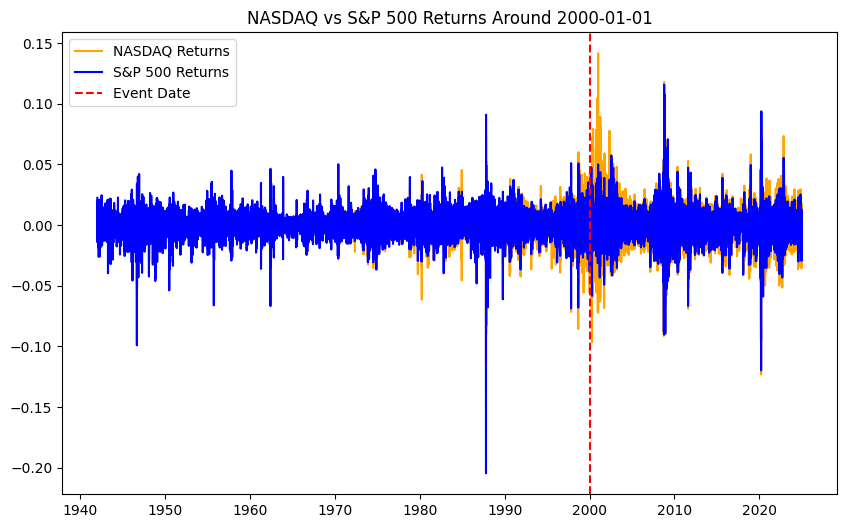

Regression Coefficients: [ 0.04218062 -0.18800414]
Intercept: 7.90437513289732e-18


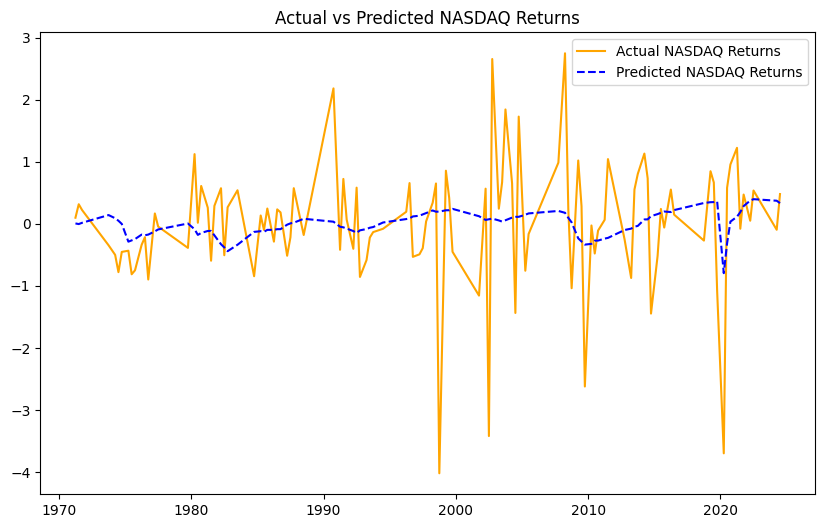

In [2]:
# Define event-driven analysis function
def event_driven_change(event_date, df, column_name, days=30):
    """
    Calculate the percentage change in a specified column after a given event date.
    """
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} does not exist in the DataFrame.")
    
    # Check if the event_date is in the dataframe
    if event_date not in df.index:
        # Find the closest available date (nearest)
        timedeltas = df.index - event_date
        closest_date = df.index[(np.abs(timedeltas)).argmin()]
        print(f"Event date {event_date} not found. Using closest available date: {closest_date}")
        event_date = closest_date
    
    # Get the value on the event date for the selected column
    value_on_event_date = df.loc[event_date, column_name]
    
    # Calculate the end date (30 days later)
    end_date = event_date + pd.Timedelta(days=days)
    
    # Check if end_date exists in the DataFrame, if not, use the closest available date
    if end_date not in df.index:
        # Find the closest available end_date (bfill)
        timedeltas = df.index - end_date
        end_date = df.index[(np.abs(timedeltas)).argmin()]
        print(f"End date {end_date} not found. Using closest available date.")
    
    # Get the value 30 days after the event date
    value_30_days_after = df.loc[end_date, column_name]
    
    # Calculate the percentage change
    if value_on_event_date == 0:
        return np.nan  # Avoid division by zero
    percentage_change = (value_30_days_after - value_on_event_date) / value_on_event_date * 100
    
    return percentage_change

# Example: Test event-driven changes for ^IXIC and S&P 500 during an event (e.g., geopolitical risk event)
event_date = pd.Timestamp('2000-01-01')
nasdaq_change = event_driven_change(event_date, df_yahoo_returns, '^IXIC')
sp500_change = event_driven_change(event_date, df_yahoo_returns, '^GSPC')

print(f"NASDAQ Change after event: {nasdaq_change}%")
print(f"S&P 500 Change after event: {sp500_change}%")

# Visualize the event-driven analysis (NASDAQ vs S&P 500)
plt.figure(figsize=(10,6))
plt.plot(df_yahoo_returns.index, df_yahoo_returns['^IXIC'], label='NASDAQ Returns', color='orange')
plt.plot(df_yahoo_returns.index, df_yahoo_returns['^GSPC'], label='S&P 500 Returns', color='blue')
plt.axvline(x=event_date, color='red', linestyle='--', label='Event Date')
plt.title(f"NASDAQ vs S&P 500 Returns Around {event_date.strftime('%Y-%m-%d')}")
plt.legend()
plt.show()

# Extract relevant FRED variables (GDP and Unemployment Rate)
gdp_data = df_fred[df_fred['Ticker'] == 'GDP'][['Value']].rename(columns={'Value': 'GDP'})
unemployment_data = df_fred[df_fred['Ticker'] == 'UNRATE'][['Value']].rename(columns={'Value': 'Unemployment Rate'})

# Merge the dataframes: Yahoo returns and FRED data
df_combined = pd.concat([df_yahoo_returns['^IXIC'], gdp_data, unemployment_data], axis=1).dropna()

# Standardize the data (important for regression)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns, index=df_combined.index)

# Linear Regression Model
X = df_scaled[['GDP', 'Unemployment Rate']]  # Independent variables (predictors)
y = df_scaled['^IXIC']  # Dependent variable (target)

# Create and fit the regression model
model = LinearRegression()
model.fit(X, y)

# Output coefficients and intercept
print(f"Regression Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

# Predict NASDAQ returns using the model
df_scaled['Predicted ^IXIC'] = model.predict(X)

# Plot the actual vs predicted NASDAQ returns
plt.figure(figsize=(10, 6))
plt.plot(df_scaled.index, df_scaled['^IXIC'], label='Actual NASDAQ Returns', color='orange')
plt.plot(df_scaled.index, df_scaled['Predicted ^IXIC'], label='Predicted NASDAQ Returns', color='blue', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted NASDAQ Returns')
plt.show()


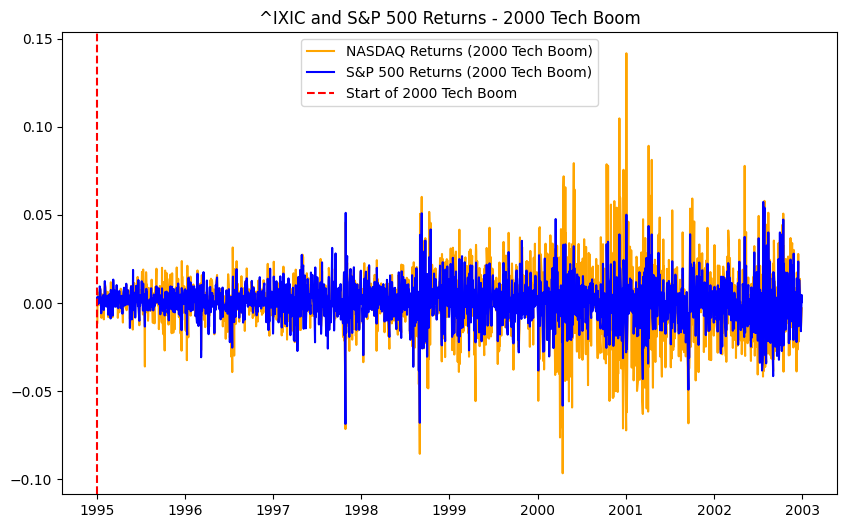

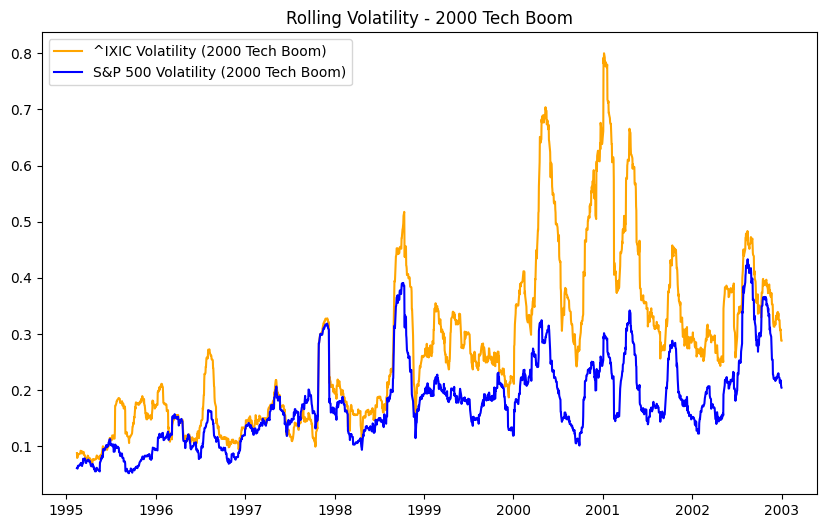

Sharpe Ratio (2000 Tech Boom): 0.35426276260052986
Max Drawdown (2000 Tech Boom): -0.779323862859341
Correlation between NASDAQ and S&P 500 (2000 Tech Boom): 0.8315468860348029


In [3]:
def filter_data_by_period(df, period):
    start_date, end_date = time_periods[period]
    return date_filter(df, start_date, end_date)

# Volatility calculation function
def calculate_rolling_volatility(df, window=30):
    return df.rolling(window=window).std() * np.sqrt(252)  # Annualized volatility

# Sharpe ratio function
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252  # Assume daily risk-free rate
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# Drawdown function
def calculate_drawdowns(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()  # Return max drawdown

# Correlation function
def calculate_correlation(df, col1, col2):
    return df[col1].corr(df[col2])

# # Filter data for different periods
# df_yahoo_returns_post_2022 = filter_data_by_period(df_yahoo_returns, "Post-2022 AI Tech Boom")
# df_yahoo_returns_cold_war = filter_data_by_period(df_yahoo_returns, "Cold War")
df_yahoo_returns_2000_boom = filter_data_by_period(df_yahoo_returns, "2000 Tech Boom")

plt.figure(figsize=(10, 6))
plt.plot(df_yahoo_returns_2000_boom.index, df_yahoo_returns_2000_boom['^IXIC'], label='NASDAQ Returns (2000 Tech Boom)', color='orange')
plt.plot(df_yahoo_returns_2000_boom.index, df_yahoo_returns_2000_boom['^GSPC'], label='S&P 500 Returns (2000 Tech Boom)', color='blue')
plt.axvline(x=pd.Timestamp('1995-01-01'), color='red', linestyle='--', label='Start of 2000 Tech Boom')
plt.title('^IXIC and S&P 500 Returns - 2000 Tech Boom')
plt.legend()
plt.show()


volatility_nasdaq_2000_boom = calculate_rolling_volatility(df_yahoo_returns_2000_boom['^IXIC'])
volatility_sp500_2000_boom = calculate_rolling_volatility(df_yahoo_returns_2000_boom['^GSPC'])


plt.figure(figsize=(10, 6))
plt.plot(volatility_nasdaq_2000_boom.index, volatility_nasdaq_2000_boom, label='^IXIC Volatility (2000 Tech Boom)', color='orange')
plt.plot(volatility_sp500_2000_boom.index, volatility_sp500_2000_boom, label='S&P 500 Volatility (2000 Tech Boom)', color='blue')
plt.title('Rolling Volatility - 2000 Tech Boom')
plt.legend()
plt.show()


sharpe_2000_boom = calculate_sharpe_ratio(df_yahoo_returns_2000_boom['^IXIC'])

drawdown_2000_boom = calculate_drawdowns(df_yahoo_returns_2000_boom['^IXIC'])

# Output Sharpe ratio and max drawdown results

print(f"Sharpe Ratio (2000 Tech Boom): {sharpe_2000_boom}")

print(f"Max Drawdown (2000 Tech Boom): {drawdown_2000_boom}")

# Correlation analysis

correlation_2000_boom = calculate_correlation(df_yahoo_returns_2000_boom, '^IXIC', '^GSPC')
print(f"Correlation between NASDAQ and S&P 500 (2000 Tech Boom): {correlation_2000_boom}")


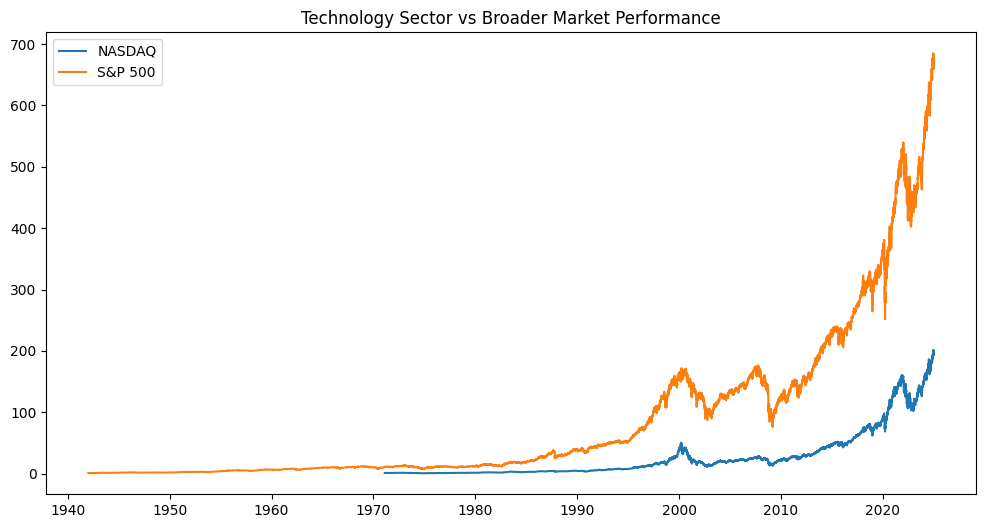

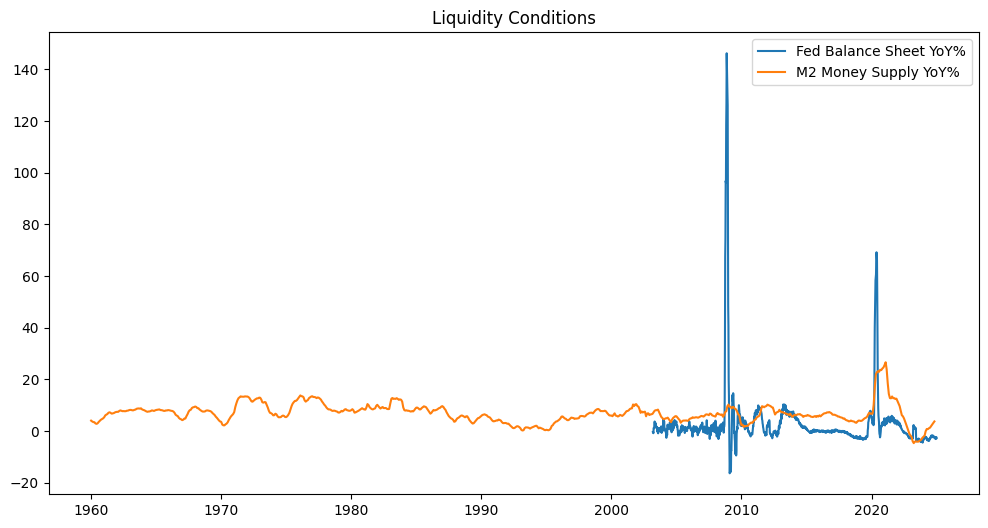

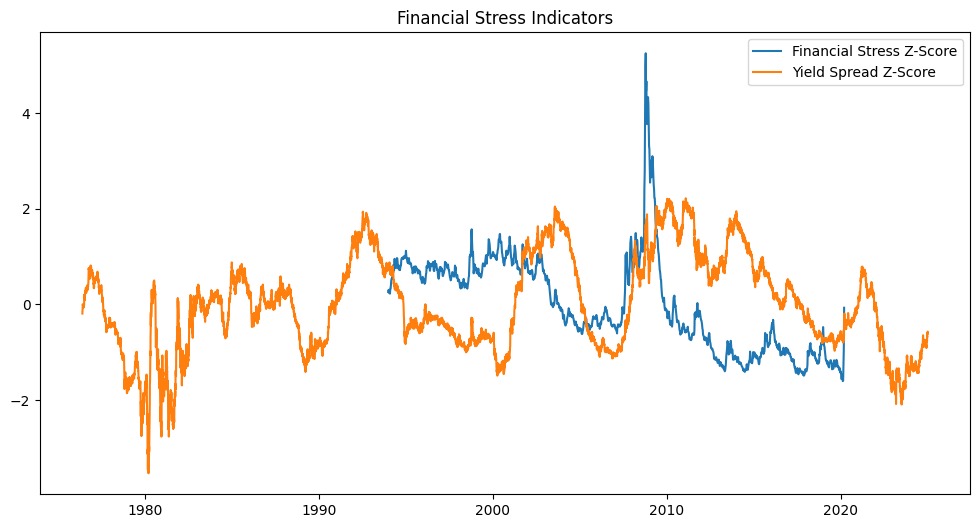


=== Macro Research Summary ===

Tech Sector Correlation (90-day):
Mean: 0.87
Current: 0.96

Liquidity Conditions:
Fed Balance Sheet YoY%: -2.8%
M2 Money Supply YoY%: 3.7%

Financial Stress:
Current Stress Z-Score: -0.07
Current Spread Z-Score: -0.58


In [4]:
def analyze_tech_sector():
    """Analyze technology sector performance and its relationship with broader markets"""
    # Calculate tech sector relative performance
    tech_returns = df_yahoo_returns['^IXIC']  # NASDAQ as tech proxy
    sp500_returns = df_yahoo_returns['^GSPC']
    
    # Calculate rolling correlation between tech and broader market
    rolling_corr = tech_returns.rolling(window=90).corr(sp500_returns)
    
    # Plot tech sector relative performance
    plt.figure(figsize=(12, 6))
    plt.plot(tech_returns.index, (1 + tech_returns).cumprod(), label='NASDAQ')
    plt.plot(sp500_returns.index, (1 + sp500_returns).cumprod(), label='S&P 500')
    plt.title('Technology Sector vs Broader Market Performance')
    plt.legend()
    plt.show()
    
    return rolling_corr

def analyze_liquidity_conditions():
    """Analyze market liquidity conditions"""
    # Extract liquidity indicators
    fed_balance = df_fred[df_fred['Ticker'] == 'WALCL']['Value']
    reverse_repo = df_fred[df_fred['Ticker'] == 'RRPONTSYD']['Value']
    money_supply = df_fred[df_fred['Ticker'] == 'M2SL']['Value']
    
    # Calculate year-over-year changes
    fed_balance_yoy = fed_balance.pct_change(periods=12) * 100
    money_supply_yoy = money_supply.pct_change(periods=12) * 100
    
    # Plot liquidity conditions
    plt.figure(figsize=(12, 6))
    plt.plot(fed_balance_yoy.index, fed_balance_yoy, label='Fed Balance Sheet YoY%')
    plt.plot(money_supply_yoy.index, money_supply_yoy, label='M2 Money Supply YoY%')
    plt.title('Liquidity Conditions')
    plt.legend()
    plt.show()
    
    return fed_balance_yoy, money_supply_yoy

def analyze_financial_stress():
    """Analyze financial stress indicators"""
    # Extract stress indicators
    stress_index = df_fred[df_fred['Ticker'] == 'STLFSI']['Value']
    yield_spread = df_fred[df_fred['Ticker'] == 'T10Y2Y']['Value']
    
    # Calculate z-scores for stress indicators
    stress_z = (stress_index - stress_index.mean()) / stress_index.std()
    spread_z = (yield_spread - yield_spread.mean()) / yield_spread.std()
    
    # Plot stress indicators
    plt.figure(figsize=(12, 6))
    plt.plot(stress_z.index, stress_z, label='Financial Stress Z-Score')
    plt.plot(spread_z.index, spread_z, label='Yield Spread Z-Score')
    plt.title('Financial Stress Indicators')
    plt.legend()
    plt.show()
    
    return stress_z, spread_z

def generate_final_report():
    """Generate comprehensive analysis report"""
    # Run all analyses
    tech_corr = analyze_tech_sector()
    fed_balance_yoy, money_supply_yoy = analyze_liquidity_conditions()
    stress_z, spread_z = analyze_financial_stress()
    
    # Print summary statistics
    print("\n=== Macro Research Summary ===")
    
    print("\nTech Sector Correlation (90-day):")
    print(f"Mean: {tech_corr.mean():.2f}")
    print(f"Current: {tech_corr.iloc[-1]:.2f}")
    
    print("\nLiquidity Conditions:")
    print(f"Fed Balance Sheet YoY%: {fed_balance_yoy.iloc[-1]:.1f}%")
    print(f"M2 Money Supply YoY%: {money_supply_yoy.iloc[-1]:.1f}%")
    
    print("\nFinancial Stress:")
    print(f"Current Stress Z-Score: {stress_z.iloc[-1]:.2f}")
    print(f"Current Spread Z-Score: {spread_z.iloc[-1]:.2f}")

# Run the complete analysis
if __name__ == "__main__":
    generate_final_report()

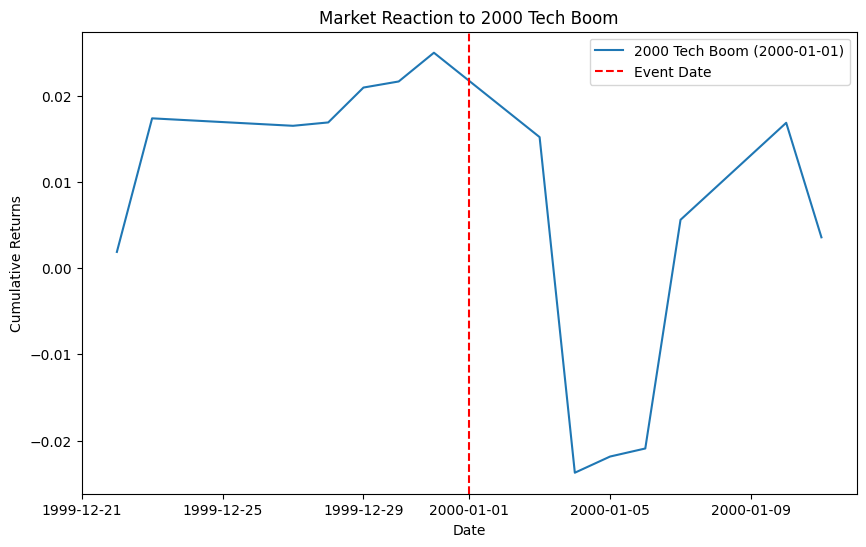

  Event Date  Pre-Event Volatility  Post-Event Volatility
0 2000-01-01              0.111537               0.259652


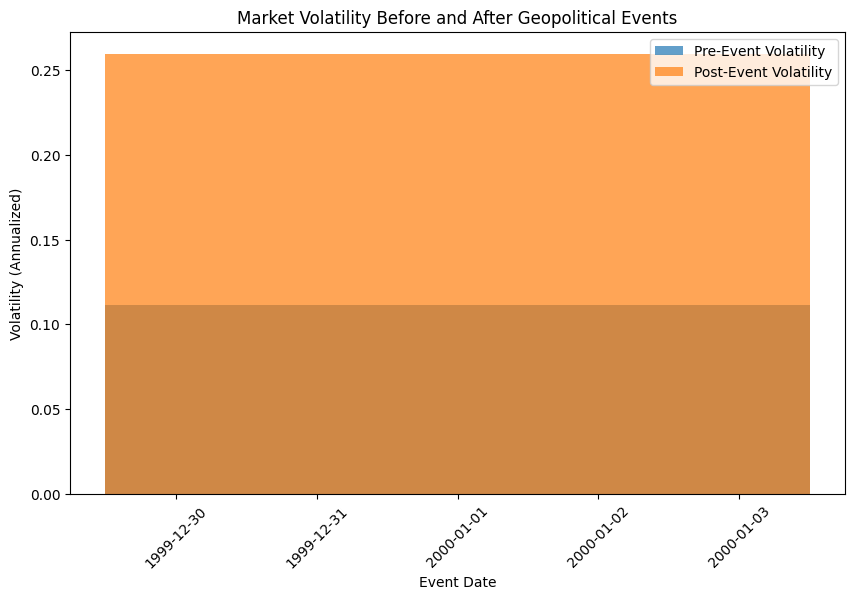

In [5]:
# Sample Geopolitical Events data
# You can replace this with your actual events dataset

time_periods = {
    "2000 Tech Boom": ("1995-01-01", "2002-12-31")
}
geopolitical_events = pd.DataFrame({
    'Date': ['2000-01-01'],
    'Event Type': ['2000 Tech Boom'],
    'Event Description': [
        '2000 Tech Boom',
    ]
})
geopolitical_events['Date'] = pd.to_datetime(geopolitical_events['Date'])

# Function to analyze market reaction to geopolitical events
def analyze_geopolitical_impact(df_yahoo_returns, events_df, market_ticker='^GSPC', window=10):
    """
    Analyze market reaction to geopolitical events.
    
    Args:
        df_yahoo_returns: DataFrame of market returns, indexed by date.
        events_df: DataFrame containing geopolitical events.
        market_ticker: Ticker symbol of the market index to analyze (default: S&P 500).
        window: Window size for calculating cumulative returns before and after the event (default: 10 days).
    
    Returns:
        None
    """
    market_returns = df_yahoo_returns[market_ticker]  # Market returns (S&P 500 in this case)
    
    # For each event, analyze the market reaction
    for _, event in events_df.iterrows():
        event_date = event['Date']
        
        # Get data around the event date (window before and after the event)
        start_date = event_date - pd.Timedelta(days=window)
        end_date = event_date + pd.Timedelta(days=window)
        
        event_data = market_returns[(market_returns.index >= start_date) & (market_returns.index <= end_date)]
        
        # Calculate cumulative returns around the event
        cumulative_returns = (1 + event_data).cumprod() - 1
        
        # Plot market reaction to the event
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_returns.index, cumulative_returns, label=f"{event['Event Type']} ({event['Date'].date()})")
        plt.axvline(event_date, color='red', linestyle='--', label='Event Date')
        plt.title(f"Market Reaction to {event['Event Type']}")
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend(loc='best')
        plt.show()

# Example: Analyze impact of geopolitical events on S&P 500 returns
analyze_geopolitical_impact(df_yahoo_returns, geopolitical_events, market_ticker='^GSPC', window=10)


# Function to calculate volatility around geopolitical events
def calculate_volatility(df, event_dates, market_ticker='^GSPC', window=30):
    """
    Calculate volatility around key events.
    
    Args:
        df: DataFrame containing market returns.
        event_dates: List of event dates to analyze.
        market_ticker: Ticker symbol of the market index to analyze (default: S&P 500).
        window: Window size in days (default: 30).
    
    Returns:
        volatility_df: DataFrame containing the calculated volatility.
    """
    volatility_list = []  # To collect the results
    
    for event_date in event_dates:
        # Define the start and end date windows for pre and post-event periods
        pre_event_start = event_date - pd.Timedelta(days=window)
        post_event_end = event_date + pd.Timedelta(days=window)
        
        # Calculate volatility as standard deviation of returns over the window
        pre_event_data = df[(df.index >= pre_event_start) & (df.index < event_date)]
        post_event_data = df[(df.index > event_date) & (df.index <= post_event_end)]
        
        pre_event_volatility = pre_event_data.std() * np.sqrt(252)  # Annualized volatility
        post_event_volatility = post_event_data.std() * np.sqrt(252)  # Annualized volatility
        
        # Append the calculated volatilities as a dict
        volatility_list.append({
            'Event Date': event_date,
            'Pre-Event Volatility': pre_event_volatility[market_ticker],
            'Post-Event Volatility': post_event_volatility[market_ticker]
        })
    
    # Convert the list of dictionaries into a DataFrame
    volatility_df = pd.DataFrame(volatility_list)
    
    return volatility_df

# Example: Calculate and print volatility before and after major geopolitical events
volatility_df = calculate_volatility(df_yahoo_returns, geopolitical_events['Date'], window=30)
print(volatility_df)

# Plot volatility comparison before and after events
def plot_volatility_comparison(volatility_df):
    """
    Plot a comparison of pre- and post-event volatilities.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(volatility_df['Event Date'], volatility_df['Pre-Event Volatility'], width=5, label='Pre-Event Volatility', alpha=0.7)
    plt.bar(volatility_df['Event Date'], volatility_df['Post-Event Volatility'], width=5, label='Post-Event Volatility', alpha=0.7)
    plt.xlabel('Event Date')
    plt.ylabel('Volatility (Annualized)')
    plt.title('Market Volatility Before and After Geopolitical Events')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.show()

# Visualize the volatility comparison
plot_volatility_comparison(volatility_df)
